# Задача:
* от заказчика передан был пример выгрузки из канала https://disk.yandex.ru/d/NcyC_Xp0EyE8ow
Что нужно сделать:

* распарсить json и положить в структуру pandas DataFrame. Пример того, что ожидается https://drive.google.com/file/d/1Ry4zMi91-qqUVLds2OVCmmG95kH8gllt/view?usp=sharing  

каждый участник создает свою ветку и пушит код парсинга

# Парсинг

In [1]:
import json
import pandas as pd
import os

In [2]:
# робота с Google Диском
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Путь к json ввожу вручную
%cd /content/drive/My Drive/Colab Notebooks/Projects/Master_Ya
path_json = os.getcwd() + '/down/маркетинг/result.json'
path_json

/content/drive/My Drive/Colab Notebooks/Projects/Master_Ya


'/content/drive/My Drive/Colab Notebooks/Projects/Master_Ya/down/маркетинг/result.json'

In [4]:
# Загружаем JSON-файл
with open(path_json, 'r', encoding='utf-8') as file:
    chat_data = json.load(file)

In [5]:
# Извлекаем сообщения, а также название чата(в JSON-файл один чат) и chat_id
messages = chat_data.get('messages', [])
chat_name = chat_data.get('name')
chat_id = chat_data.get('id')

In [6]:
# Парсим текстовые сообщения
parsed_messages = []
for message in messages:
    # отсекаем служебные сообщения  type: service
    if message.get('type') == 'message':
        text = message['text']
        parsed_messages.append({
            'message_id': message['id'],
            'date': message['date'],
            'chat_name': chat_name,
            'chat_id': chat_id,
            'sender_id': message.get('from_id'),
            'from': message.get('from', 'Unknown'),
            'text': text
        })

In [7]:
# Создаем датафрейм
df = pd.DataFrame(parsed_messages)

In [8]:
df

,message_id,date,chat_name,chat_id,sender_id,from,text
0,42471,2025-02-01T07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы..."
1,42472,2025-02-01T07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"А вот регионы, в которых живут ITшники с интер..."
2,42473,2025-02-01T07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"Если смотреть по интересам, то кажется, что ау..."
3,42474,2025-02-01T07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,А путь пользователя почему-то выглядит так. Ко...
4,42475,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Опять он
...,...,...,...,...,...,...,...
3675,46400,2025-02-27T20:11:04,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,"Напишу им, спасибо."
3676,46401,2025-02-27T20:23:08,💬 Marketing Practicum Chat,1782474569,user1912824918,S,"Старые профили не удаляются, номер на который ..."
3677,46402,2025-02-27T20:24:44,💬 Marketing Practicum Chat,1782474569,user1912824918,S,Пишите оператору (позовите пожалуйста оператор...
3678,46403,2025-02-27T20:29:44,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,Отлично! Благодарю.


In [9]:
df.head(10).style.set_properties(**{'text-align': 'left', 'white-space': 'pre-wrap'})

,message_id,date,chat_name,chat_id,sender_id,from,text
0,42471,2025-02-01T07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"['Доброе утро, люди! Это ОК, в РСЯ алгоритмы выбрали только 1 площадку для объявлений? Объект рекламы - ""консультации для IT компаний"". Почему решили все объявления показывать на ', {'type': 'link', 'text': 'game.yandex.ru'}, ', Я в корректировках рекламной кампании поставил ограничения аудитории по возрасту, от 24 лет... Получается, что все айтишники старше 24 лет обитают в играх Яндекс?']"
1,42472,2025-02-01T07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"А вот регионы, в которых живут ITшники с интересом к нашему предложению. Эти люди провели на сайте больше 1 минуты"
2,42473,2025-02-01T07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,"Если смотреть по интересам, то кажется, что аудитория релевантная"
3,42474,2025-02-01T07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,А путь пользователя почему-то выглядит так. Конверсий в заявку нету😭
4,42475,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Опять он
5,42476,2025-02-01T08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,
6,42477,2025-02-01T08:15:13,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,Потому и выбрал
7,42478,2025-02-01T08:15:32,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,"Ну если это вся статистика, то пока алгоритм еще ничего не выбрал"
8,42479,2025-02-01T08:16:44,💬 Marketing Practicum Chat,1782474569,user87502689,Андрей Дамаскин,"Чтобы 34 визита из РСЯ превратились в заявку нужна конверсия на уровне 3%, для необученной РК не реально же"
9,42480,2025-02-01T08:17:32,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,Батя привет


# Кластеризация по reply и по соседним сообщениям с временным threshold`ом

In [10]:
# Добавил в парсинг reply_to_message_id
parsed_messages = []
for message in messages:
    if message.get('type') == 'message':
        text = message['text']
        parsed_messages.append({
            'message_id': message['id'],
            'date': message['date'],
            'chat_name': chat_name,
            'chat_id': chat_id,
            'sender_id': message.get('from_id'),
            'from': message.get('from', 'Unknown'),
            'reply_to_message_id': message.get('reply_to_message_id'),
            'text': text
        })

In [11]:
df = pd.DataFrame(parsed_messages)

In [12]:
# Собирю пары Id сообщений по reply_to_message_id
x = []
for i in range(len(df)-1, -1, -1):
  if not pd.isna(df.loc[i, 'reply_to_message_id']):
    x.append([df.loc[i, 'message_id'], df.loc[i, 'reply_to_message_id']])

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
# Добавляю пары соседних сообщений с порогом в полминуты
# Порог выбрал в ручную, при таком порого 1500 событий
th_minute=0.5
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=th_minute):
    x.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])

In [15]:
# Количество пар(связей)
len(x)

3809

In [16]:
para = pd.DataFrame(x, columns=['one','two'])

In [17]:
para['two'] = para['two'].astype('int')

In [18]:
para

,one,two
0,46405,46403
1,46403,46402
2,46401,46394
3,46398,46396
4,46396,46394
...,...,...
3804,46395,46396
3805,46396,46397
3806,46397,46398
3807,46398,46399


In [19]:
para.loc[0, 'one']

np.int64(46405)

In [20]:
# Составляем списки id сообщений в диалоги с помощью networkx
import networkx as nx

# Создаем граф из пар значений
G = nx.Graph()
for _, row in para.iterrows():
    G.add_edge(row['one'], row['two'])

# Находим связные компоненты
connected_components = list(nx.connected_components(G))

# Преобразуем в список списков и сортируем каждый подсписок
result = [sorted(list(component)) for component in connected_components]

# Сортируем общий список по первому элементу каждого подсписка
result.sort(key=lambda x: x[0])

print(result[1:3])

[[np.int64(42473), np.int64(42477), np.int64(42478), np.int64(42480), np.int64(42481)], [np.int64(42475), np.int64(42476), np.int64(42554)]]


In [21]:
# Количество диалогов
len(result)

341

In [22]:
# Количество сообщений попавших в диалоги
total = sum(len(sublist) for sublist in result)
total

3459

In [23]:
# Количество сообщенией в наибольшем диалоге
total = max(len(sublist) for sublist in result)
total

103

In [24]:
# Сортирую
sorted_result = sorted(result, key=lambda x: len(x), reverse=True)

In [25]:
# Топ 10 диалогов
sorted_result = sorted_result[0:10]

In [26]:
# Отображаю 10 место
cluster_10 = df.loc[df['message_id'].isin(sorted_result[9]), 'text']#.tolist()
print('Количество сообщений в диалоге ', len(cluster_10))
with pd.option_context('display.max_colwidth', 200):
    print(cluster_10)

Количество сообщений в диалоге  51
1509                                                                                                                        А пока сижу я такой, листаю и вижу эти "глаза" \nДумал такое банят, но видимо нет 😅
1510                                                                                              Слишком читерский креатив, ибо на другое смотреть сложно 😅😂Что скажете коллеги? одобряемс? или фу так делать?
1511                                                                                                                                                                          пресс вижу, спортиком занимается?
1512                                                                                                                                                                                       Либо пфотоджопсиком.
1513    Простите, что я опять о своем... Директ всю неделю гнал мусорный трафик. Видимо, "вумные алгоритмы" так хорошо учатся. В пятн

Вывод: Провел кластеризацию по reply и по соседним сообщениям с временным threshold`ом. Порог по времени пол минуты. Получил 341 диалог. Выделил самые длинные (10шт). 103 собщения в самом большом, 51 в маленьком. Метрику оценил пока только визульно(почитал сообщения в диалоге). Связь между сообщениями прослеживается.

# Кластеризация по всплескам активности по времени

In [27]:
df

,message_id,date,chat_name,chat_id,sender_id,from,reply_to_message_id,text
0,42471,2025-02-01 07:35:54,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"[Доброе утро, люди! Это ОК, в РСЯ алгоритмы вы..."
1,42472,2025-02-01 07:40:03,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"А вот регионы, в которых живут ITшники с интер..."
2,42473,2025-02-01 07:48:53,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,"Если смотреть по интересам, то кажется, что ау..."
3,42474,2025-02-01 07:50:31,💬 Marketing Practicum Chat,1782474569,user1272493086,Pasha Sannikov,NaN,А путь пользователя почему-то выглядит так. Ко...
4,42475,2025-02-01 08:12:42,💬 Marketing Practicum Chat,1782474569,user1164775873,Данилов | Маркетолог,NaN,Опять он
...,...,...,...,...,...,...,...,...
3675,46400,2025-02-27 20:11:04,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,NaN,"Напишу им, спасибо."
3676,46401,2025-02-27 20:23:08,💬 Marketing Practicum Chat,1782474569,user1912824918,S,46394.0,"Старые профили не удаляются, номер на который ..."
3677,46402,2025-02-27 20:24:44,💬 Marketing Practicum Chat,1782474569,user1912824918,S,NaN,Пишите оператору (позовите пожалуйста оператор...
3678,46403,2025-02-27 20:29:44,💬 Marketing Practicum Chat,1782474569,user1829741608,Алексей Ермолов,46402.0,Отлично! Благодарю.


1. Линейный график сообщений по дням (агрегация по дням)

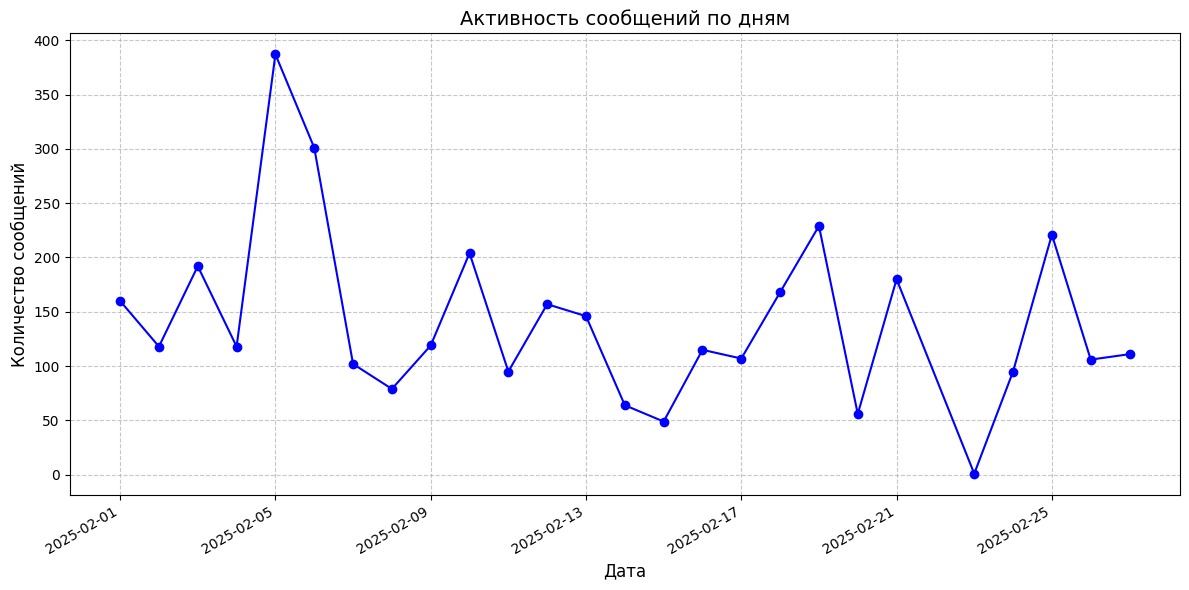

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Группируем по дате (без времени) и считаем количество сообщений
daily_counts = df['date'].dt.floor('D').value_counts().sort_index()

# Настраиваем график
plt.figure(figsize=(12, 6))
daily_counts.plot(kind='line', marker='o', color='blue', linestyle='-')

# Добавляем подписи
plt.title('Активность сообщений по дням', fontsize=14)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество сообщений', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-29-43154eed6413>:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


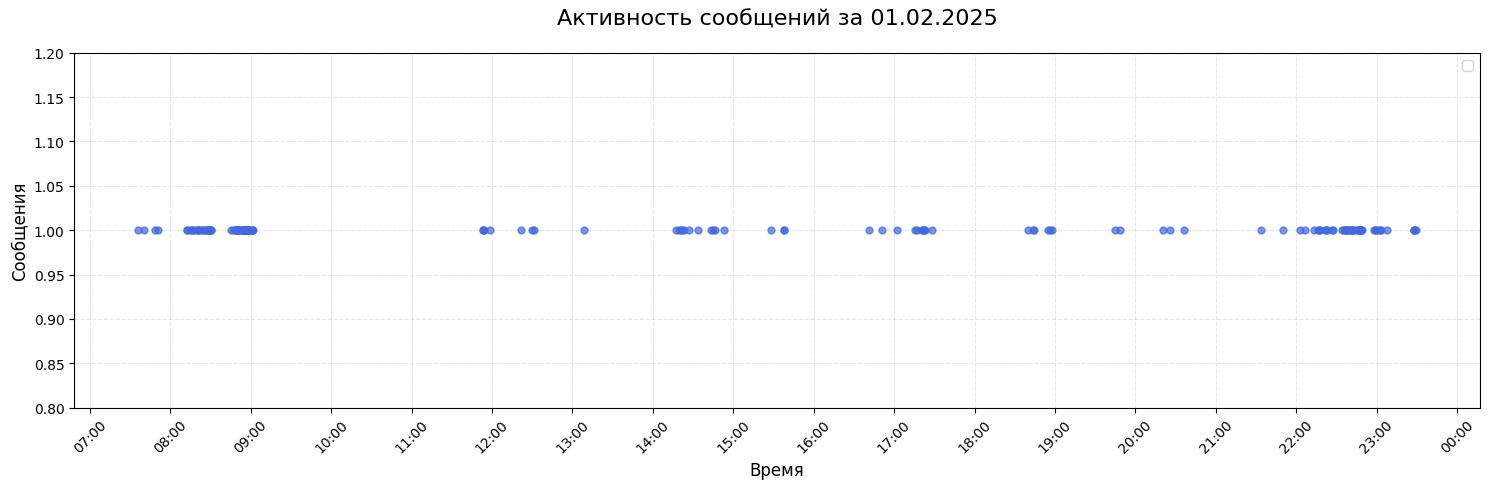

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, HourLocator, MinuteLocator

# Выбираем только первый день
first_day = df['date'].dt.date.min()
df_day = df[df['date'].dt.date == first_day].copy()

# Настройка стиля
plt.figure(figsize=(15, 5))

# Создаем график
ax = plt.gca()

# Вариант 1: Точечный график (каждое сообщение как точка)
ax.plot(df_day['date'],
        [1]*len(df_day),  # Все точки на y=1
        marker='o',
        markersize=5,
        linestyle='',
        alpha=0.7,
        color='royalblue')

# Настройка временной оси
ax.xaxis.set_major_locator(HourLocator(interval=1))  # Основные деления - каждый час
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))  # Формат времени

# Подписи и оформление
plt.title(f'Активность сообщений за {first_day.strftime("%d.%m.%Y")}', fontsize=16, pad=20)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Сообщения', fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.3)
plt.ylim(0.8, 1.2)  # Для точечного графика

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Пороговое значения всплеска

In [30]:
threshold_vspl = 30

In [31]:
# Добавляю пары соседних сообщений с порогом в 30 минут (в прошлом методе было 30 секунд)
# Порог выбрал вручную, глядя на графики активности сообщений
threshold_vspl = 30
y = []
for i in range(len(df)-1):
  if df.loc[i+1, 'date']-df.loc[i, 'date'] < pd.Timedelta(minutes=threshold_vspl):
    y.append([df.loc[i, 'message_id'], df.loc[i+1, 'message_id']])
len(y)

3466

In [32]:
para_vspl = pd.DataFrame(y, columns=['one','two'])
para_vspl

,one,two
0,42471,42472
1,42472,42473
2,42473,42474
3,42474,42475
4,42475,42476
...,...,...
3461,46399,46400
3462,46400,46401
3463,46401,46402
3464,46402,46403


In [33]:
# Составляем списки id сообщений в диалоги с помощью networkx
G = nx.Graph()
for _, row in para_vspl.iterrows():
    G.add_edge(row['one'], row['two'])
connected_components = list(nx.connected_components(G))
result = [sorted(list(component)) for component in connected_components]
result.sort(key=lambda x: x[0])
print(result[1:3])

[[np.int64(42543), np.int64(42544), np.int64(42545), np.int64(42546), np.int64(42547), np.int64(42548), np.int64(42549)], [np.int64(42554), np.int64(42555), np.int64(42556), np.int64(42557), np.int64(42558), np.int64(42559), np.int64(42560), np.int64(42561), np.int64(42562), np.int64(42563), np.int64(42564)]]


In [34]:
# Количество диалогов
len(result)

153

In [35]:
# Количество сообщений попавших в диалоги
total = sum(len(sublist) for sublist in result)
total

3619

In [36]:
# Количество сообщенией в наибольшем диалоге
total = max(len(sublist) for sublist in result)
total

206

In [37]:
# Сортирую
result_vspl = sorted(result, key=lambda x: len(x), reverse=True)
result_vspl = result_vspl[0:10]

In [38]:
# Отображаю 10 место
cluster_10 = df.loc[df['message_id'].isin(result_vspl[9]), 'text']#.tolist()
print('Количество сообщений в диалоге ', len(cluster_10))
with pd.option_context('display.max_colwidth', 200):
    print(cluster_10)

Количество сообщений в диалоге  79
2565                                                                                                                                                                                                 Через гтм?
2566                                                                                                                                                                                        Через oncontextmenu
2567                                                                                                                                                                 Очень интересно, но не понятно 😂👍пример бы
2568                                                                                                                                                             oncontextmenu(ym(000000,'reachGoal','pochta'))
2569                                                                                                                                 

Вывод: Провел кластеризацию по всплескам активности. Порог по временногу интервалу между соседними сообщениями 30 минут. Получил 153 диалога. Выделил самые длинные (10шт). 206 собщений в самом большом, 79 в маленьком. Метрику оценил пока только визульно(почитал сообщения в диалоге).

# Кластеризация через ембеденги N-грамм.

Код пока не написал. Идея такая. Через rubert получаю ембеденги. Суммирую по N штук и получаю ембеденги N-грамм. N это гиперпараметр (2,3,4,5 шт). Ищу соседние N-граммы среди всех сообщение. Соседство N-грамм, а также количество соседних N-грамм, это тоже гиперпараметр. По порогам собираю диалоги. Связь между сообщениями прослеживается.